# M&A Prediction with Risk (NASDAQ MidCap)

Part II Project Overview - This phase extends the screening framework to NASDAQ MidCap companies to reflect the typical scale and structure of private equity transactions.
It integrates legal and structural risk factors and applies machine learning to generate predictive acquisition scores for target prioritization.

Ticker Filtering and Financial Data Collection

In [ ]:
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

df = pd.read_csv("nasdaq-listed-symbols.csv")
df["Company Name"] = df["Company Name"].astype(str)
df["Symbol"] = df["Symbol"].astype(str)

df = df[
    (df["ETF"] == "N") &
    (df["NextShares"] == "N") &
    (df["Test Issue"] == "N")
]

df = df[
    ~df["Company Name"].str.contains(r"(?:Acquisition\sCorp|SPAC)", case=False, na=False)
]

keywords = [
    "Trust", "Mortgage", "REIT", "Finance", "Capital", "Note",
    "Income", "Partners", "LP", "Fund", "Warrant", "ETF", "Structured"
]
pattern = "|".join(keywords)
df = df[~df["Company Name"].str.contains(pattern, case=False, na=False)]

df = df[~df["Symbol"].str.contains(r"[0-9WURX]$", regex=True)]
df = df[df["Symbol"].str.len() <= 4]
df["Symbol"] = df["Symbol"].str.replace(".", "-", regex=False)
symbols = df["Symbol"].tolist()

print(len(symbols))

def get_data(ticker, retries=2, delay=2):
    for _ in range(retries + 1):
        try:
            data = yf.Ticker(ticker).info
            if not data or "marketCap" not in data:
                return None
            return {
                "Symbol": ticker,
                "Market_Cap": data.get("marketCap"),
                "EBITDA_Margin": data.get("ebitdaMargins"),
                "ROA": data.get("returnOnAssets"),
                "Debt_Equity": data.get("debtToEquity"),
                "Sector": data.get("sector"),
                "Sub_Industry": data.get("industry")
            }
        except:
            time.sleep(delay)
    return None

all_data = []
chunk = 500

time.sleep(30)

for i in range(0, len(symbols), chunk):
    current = symbols[i:i + chunk]
    print(i, "-", i + len(current))

    with ThreadPoolExecutor(max_workers=5) as pool:
        futures = [pool.submit(get_data, s) for s in current]
        for idx, f in enumerate(as_completed(futures)):
            r = f.result()
            if r:
                all_data.append(r)
            if idx % 50 == 0:
                print(idx)

    time.sleep(180)

df_fin = pd.DataFrame(all_data)
df_fin.to_csv("midcap_financials.csv", index=False)
print(len(df_fin))

2611


Apply PE Screening Criteria

In [ ]:
df = pd.read_csv("midcap_financials.csv")

df = df.dropna(subset=[
    "Market_Cap", "EBITDA_Margin", "ROA", "Debt_Equity"
])

df = df[
    (df["Market_Cap"] >= 7.5e8) &
    (df["Market_Cap"] <= 2e10) &
    (df["EBITDA_Margin"] >= 0.065) &
    (df["ROA"] > 0) &
    (df["Debt_Equity"] < 5.5)
].reset_index(drop=True)

print("Final candidates:", len(df))
print(df[["Symbol", "Market_Cap", "EBITDA_Margin", "ROA", "Debt_Equity"]].head())

df.to_csv("pe_candidates.csv", index=False)

Final candidates: 42
  Symbol   Market_Cap  EBITDA_Margin      ROA  Debt_Equity
0   ALGN  11723897856        0.20520  0.06866        3.097
1   ALKS   4382989312        0.28837  0.12543        5.156
2   AMSF    930035648        0.22694  0.03616        0.166
3     BZ   6592960512        0.19464  0.03936        2.019
4   CART  10133155840        0.16075  0.07196        0.793


Add Legal Risk Features


In [ ]:
df = pd.read_csv("midcap_financials.csv")

sector_map = {
    "Financials": 5,
    "Healthcare": 4,
    "Energy": 4,
    "Real Estate": 3,
    "Technology": 2,
    "Industrials": 2,
    "Consumer Discretionary": 1
}

contract_keywords = {
    3: ["SaaS", "Platform", "Software", "Subscription", "Lease"],
    2: ["Wholesale", "Commercial", "Consulting", "Construction"],
    1: ["Retail", "Manufacturing", "Consumer"]
}

def get_regulatory(s):
    return sector_map.get(s, 3)

def get_contract(sub):
    for score, keys in contract_keywords.items():
        if any(k.lower() in str(sub).lower() for k in keys):
            return score
    return 2

def get_debt_risk(de):
    if de < 2:
        return 1
    elif de < 4:
        return 2
    return 3

def get_execution_complexity(name):
    if isinstance(name, str) and any(k in name for k in ["Holdings", "Group", "Acquisition", "Corp"]):
        return 1
    return 0

def get_ip_dependence(sub):
    if isinstance(sub, str) and any(k in sub.lower() for k in ["software", "platform", "brand", "media"]):
        return 1
    return 0

df["Regulatory_Risk"] = df["Sector"].apply(get_regulatory)
df["Contract_Risk"] = df["Sub_Industry"].apply(get_contract)
df["Debt_Risk"] = df["Debt_Equity"].apply(get_debt_risk)
df["Execution_Complexity"] = df["Symbol"].apply(get_execution_complexity)
df["IP_Dependence"] = df["Sub_Industry"].apply(get_ip_dependence)
df["Carveout_Flag"] = 0

df.to_csv("pe_candidates_enriched.csv", index=False)

Initial label setup for ML

In [ ]:
df = pd.read_csv("pe_candidates_enriched.csv")
label_template = df[["Symbol"]].copy()
label_template["Acquisition_Score"] = 0.0
label_template.to_csv("pe_labels_template.csv", index=False)

Final Label Assignment

In [ ]:
df = pd.read_csv("midcap_financials.csv")

confirmed = ["BZ", "CRCT", "VCYT", "MIK", "PFPT", "RP", "TLND", "STMP", "QAD", "PS", "CSOD", "CONE", "CVT", "XM", "CTXS", "MCFE", "MGI", "TECD"]
engaged = ["BLKB", "BL", "FIVN", "HEES", "RPD", "GFS", "SIMO", "WEN", "SSYS", "ODP", "NTNX", "MAT", "HOOD", "EA", "ODP", "SSYS", "WEN"]
speculated = ["PTON", "ROKU", "LCID", "EA", "HOOD", "NTNX"]

df["Acquisition_Score"] = 0.0
df.loc[df["Symbol"].isin(confirmed), "Acquisition_Score"] = 1.0
df.loc[df["Symbol"].isin(engaged), "Acquisition_Score"] = 0.7
df.loc[df["Symbol"].isin(speculated), "Acquisition_Score"] = 0.3

df[["Symbol", "Acquisition_Score"]].to_csv("pe_labels.csv", index=False)

Machine Learning

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("pe_candidates_enriched.csv")
labels = pd.read_csv("pe_labels.csv")

df = df.merge(labels, on="Symbol", how="left")
df = df.dropna(subset=["Acquisition_Score"])

sectors = [
    "Technology", "Healthcare", "Industrials", "Real Estate",
    "Consumer Discretionary", "Financials", "Energy"
]
df = df[df["Sector"].isin(sectors)]

pos = df[df["Acquisition_Score"] > 0]
neg = df[
    (df["Acquisition_Score"] == 0.0) &
    (
        (df["EBITDA_Margin"] < 0.05) |
        (df["ROA"] <= 0)
    )
]

neg = neg.sample(n=pos.shape[0]*2, random_state=42)
df = pd.concat([pos, neg]).sample(frac=1, random_state=42)

features = [
    "Market_Cap", "EBITDA_Margin", "ROA", "Debt_Equity",
    "Regulatory_Risk", "Contract_Risk", "Debt_Risk",
    "Execution_Complexity", "IP_Dependence"
]

X = df[features]
y = df["Acquisition_Score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

df["Predicted_Score"] = model.predict(df[features])
df[["Symbol", "Predicted_Score"]].sort_values(
    by="Predicted_Score", ascending=False
).to_csv("pe_predictions.csv", index=False)


MSE: 0.049633970310580394
R2 Score: 0.6666375128393855


SHAP

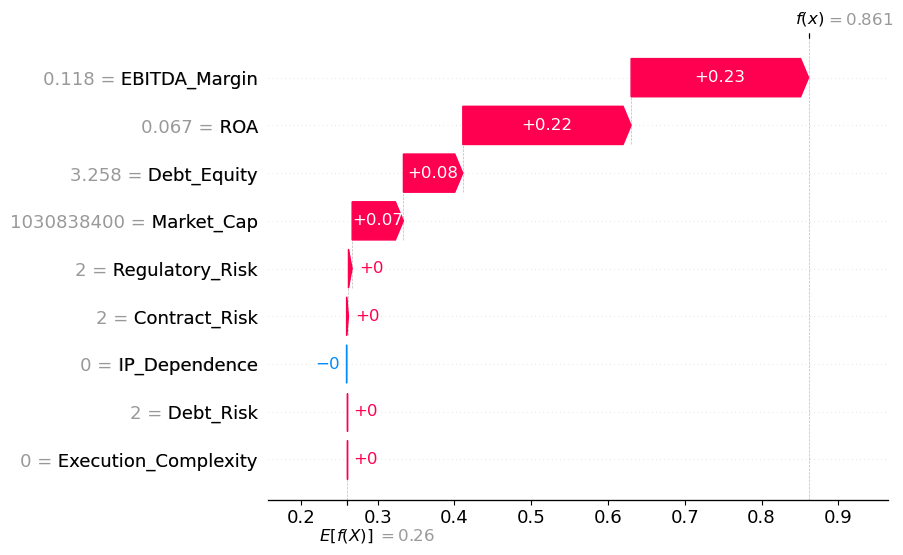

In [ ]:
import shap
import matplotlib.pyplot as plt

X = df_balanced[features]

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=300)
plt.close()

top = df_balanced.sort_values(by="Acquisition_Score", ascending=False).iloc[0]
ix = df_balanced.index.get_loc(top.name)

shap.plots.waterfall(shap_values[ix], max_display=10)
plt.tight_layout()
plt.savefig(f"shap_{top['Symbol']}.png", dpi=300)
plt.close()

Final Recommendation & Target List

In [ ]:
top_n = df.sort_values(by="Predicted_Score", ascending=False).head(10)

cols = [
    "Symbol", "Predicted_Score",
    "EBITDA_Margin", "ROA", "Debt_Equity",
    "Regulatory_Risk", "Contract_Risk", "Debt_Risk"
]

top_n[cols].to_csv("pe_recommendations_top10.csv", index=False)
top_n[cols].reset_index(drop=True)

,Symbol,Predicted_Score,EBITDA_Margin,ROA,Debt_Equity,Regulatory_Risk,Contract_Risk,Debt_Risk
0,VCYT,0.997988,0.11270,0.01386,4.314,4,2,3
1,CRCT,0.861332,0.11831,0.06712,3.258,2,2,2
2,HEES,0.725593,0.18360,0.05054,271.052,2,2,3
3,RPD,0.700587,0.09537,0.01409,5748.823,2,3,3
4,BLKB,0.700269,0.21958,0.04169,784.306,2,3,3
5,SIMO,0.700181,0.14884,0.05774,NaN,2,2,3
6,SSYS,0.699825,-0.03425,-0.03752,4.047,2,2,3
7,GFS,0.699634,0.32904,0.02612,21.443,2,2,3
8,FIVN,0.698869,0.02256,-0.01036,198.191,2,3,3
9,AXTI,0.430942,-0.05861,-0.02651,21.803,2,2,3


In [ ]:
top_10 = df.sort_values(by="Predicted_Score", ascending=False).head(10)

cols = [
    "Symbol", "Predicted_Score", "Market_Cap", "EBITDA_Margin", 
    "ROA", "Debt_Equity", "Regulatory_Risk", "Contract_Risk", "Debt_Risk"
]

top_10_info = top_10[cols]

print(top_10_info)

top_10_info.to_csv("top_10_companies_details.csv", index=False)


     Symbol  Predicted_Score   Market_Cap  EBITDA_Margin      ROA  \
2342   VCYT         0.997988   2357830144        0.11270  0.01386   
482    CRCT         0.861332   1030838400        0.11831  0.06712   
953    HEES         0.725593   3367682304        0.18360  0.05054   
1914    RPD         0.700587   1456571904        0.09537  0.01409   
319    BLKB         0.700269   2964037376        0.21958  0.04169   
2011   SIMO         0.700181   1334464896        0.14884  0.05774   
2110   SSYS         0.699825    641735488       -0.03425 -0.03752   
860     GFS         0.699634  18693990400        0.32904  0.02612   
769    FIVN         0.698869   1771129472        0.02256 -0.01036   
256    AXTI         0.430942     55173580       -0.05861 -0.02651   

      Debt_Equity  Regulatory_Risk  Contract_Risk  Debt_Risk  
2342        4.314                4              2          3  
482         3.258                2              2          2  
953       271.052                2              2  

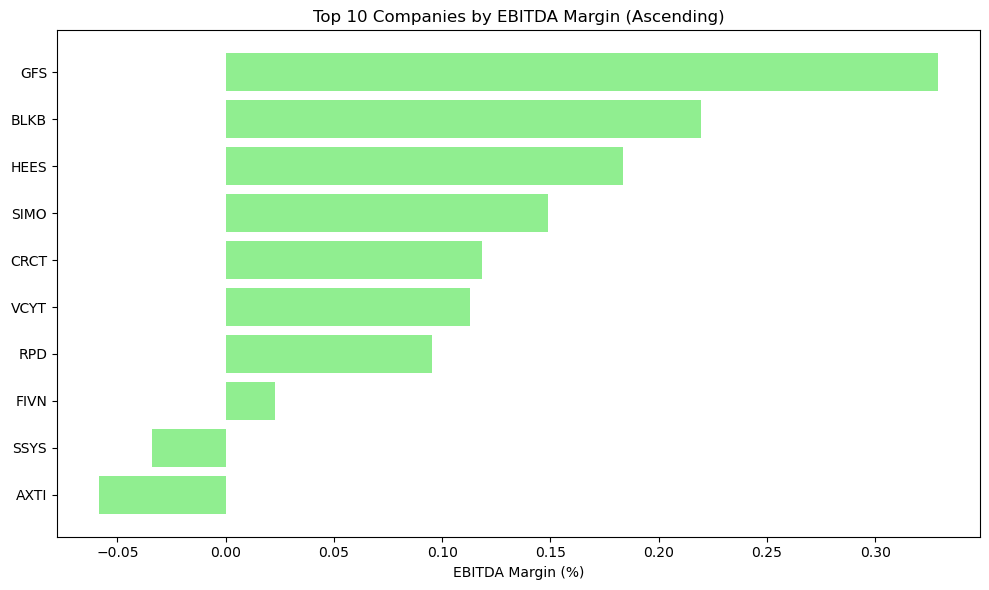

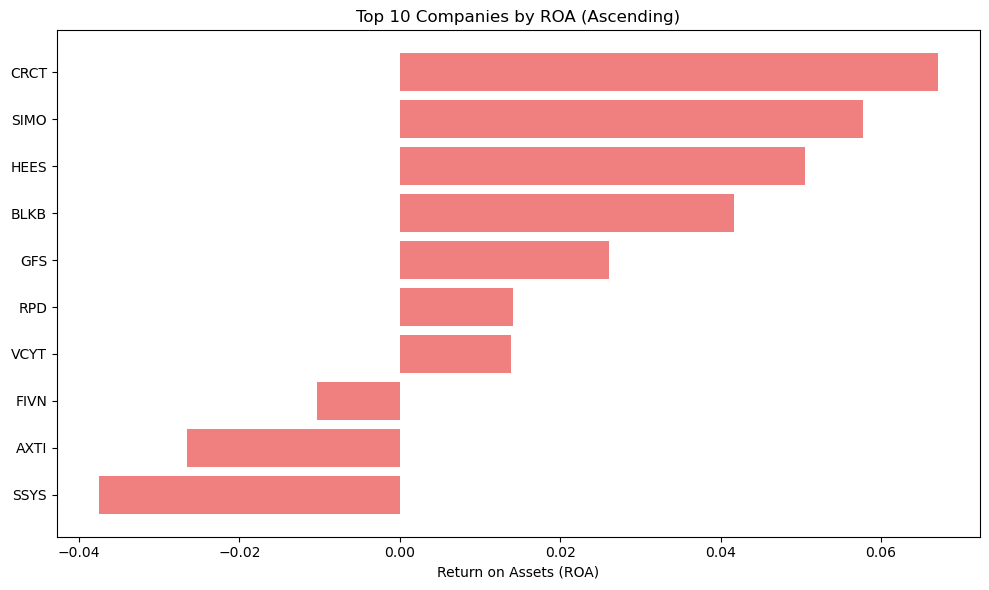

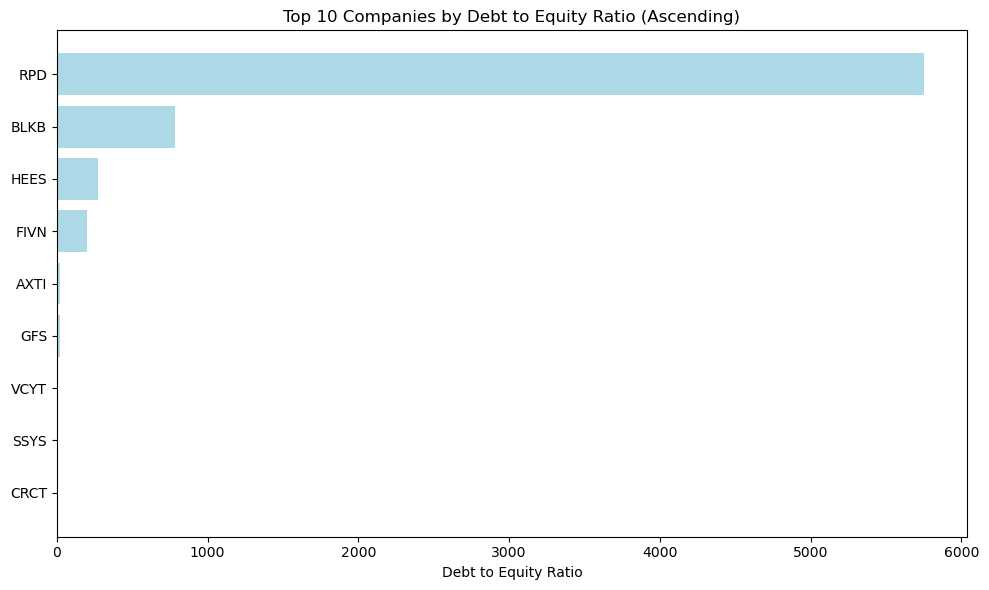

In [ ]:
top_10 = df.sort_values(by="Predicted_Score", ascending=False).head(10)

cols = [
    "Symbol", "Predicted_Score", "Market_Cap", "EBITDA_Margin", 
    "ROA", "Debt_Equity", "Regulatory_Risk", "Contract_Risk", "Debt_Risk"
]

top_10_info = top_10[cols]


plt.figure(figsize=(10,6))
top_10_info_sorted = top_10_info.sort_values(by="EBITDA_Margin", ascending=True)
plt.barh(top_10_info_sorted["Symbol"], top_10_info_sorted["EBITDA_Margin"], color="lightgreen")
plt.xlabel("EBITDA Margin (%)")
plt.title("Top 10 Companies by EBITDA Margin (Ascending)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
top_10_info_sorted = top_10_info.sort_values(by="ROA", ascending=True)
plt.barh(top_10_info_sorted["Symbol"], top_10_info_sorted["ROA"], color="lightcoral")
plt.xlabel("Return on Assets (ROA)")
plt.title("Top 10 Companies by ROA (Ascending)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
top_10_info_sorted = top_10_info.sort_values(by="Debt_Equity", ascending=True)
plt.barh(top_10_info_sorted["Symbol"], top_10_info_sorted["Debt_Equity"], color="lightblue")
plt.xlabel("Debt to Equity Ratio")
plt.title("Top 10 Companies by Debt to Equity Ratio (Ascending)")
plt.tight_layout()
plt.show()

Top 10 List 

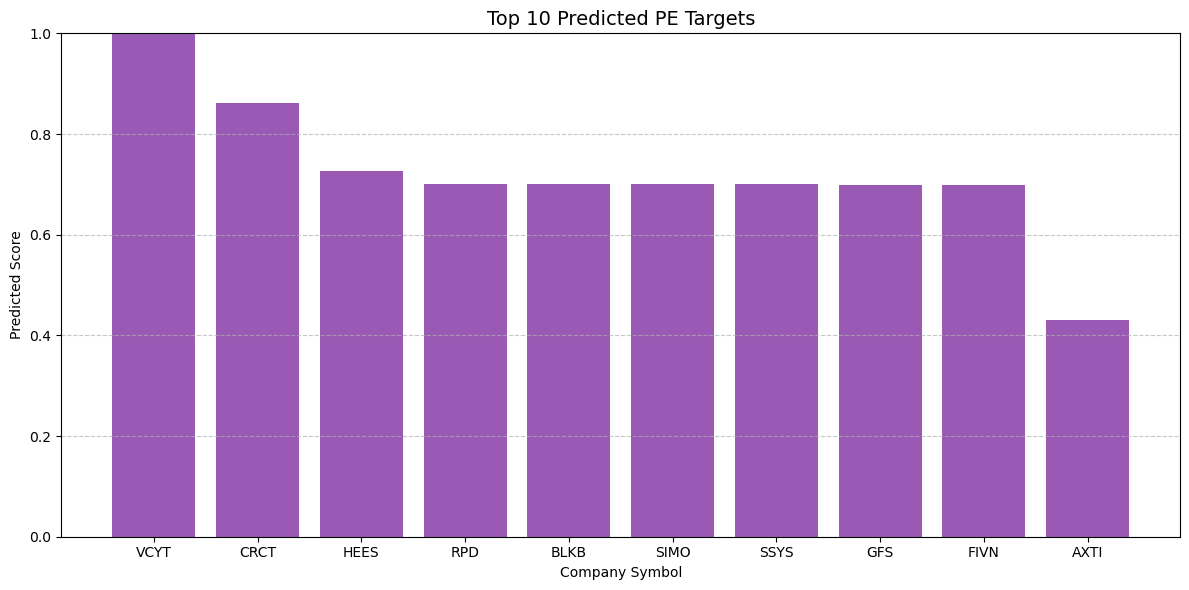

In [9]:
top10 = df.sort_values(by="Predicted_Score", ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top10["Symbol"], top10["Predicted_Score"], color="#9b59b6")
plt.ylim(0, 1)
plt.title("Top 10 Predicted PE Targets", fontsize=14)
plt.ylabel("Predicted Score")
plt.xlabel("Company Symbol")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("top10_pe_targets.png", dpi=300)
plt.show()